# CIFAR-10 Classification using Keras & Tensorflow

**Welcome to this project!**

Here you will implement a CNN to classify the CIFAR10 dataset.<br>
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.<br>
To get more info on this dataset check the tech report [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.<br>

For this task you will be using the Keras framework with Tensorflow backend.

## 1. Initial Setup

### 1.1 Import libraries

In [18]:
import sys
import os
import time as time

import utils

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("tf")

At first I trained the CNN on CPU and then installed the GPU version of Tensorflow to check the training time difference.<br>
To know more about it you may check the Tensorflow installation page https://www.tensorflow.org/install/gpu.<br>

I'm using my laptop GPU (GeForce GTX 1050 Ti).

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("You need to install the GPU version of Tensorflow")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5061982338678994801
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3161430425
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4652507663327707290
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Default GPU Device: /device:GPU:0


### 1.2 Versions used in this project

In [3]:
print('OS:', sys.platform)
print('Python:', sys.version)
print('Tensorflow:', tf.__version__)
print('Keras:', keras.__version__)

OS: win32
Python: 3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]
Tensorflow: 1.12.0
Keras: 2.2.4


### 1.3 Load Dataset

Download CIFAR-10 Dataset here: https://www.cs.toronto.edu/~kriz/cifar.html

The dataset could be easily downloaded using keras.datasets
but since the goal of this project is to get experience of the full stack of the process
let's download it directly from the CIFAR website to get it.<br>
Nevertheless you could simply use the code of the following cell to get the data.

In case you use the previous cell you can skip to the next section.

Load train set and test set <br>
Here you will be using the functions inside utils.py. The file is in the same folder of this notebook. <br>
X_train (images), y_train (class numbers), labels_train (one-hot encoded array of class numbers) <br>
X_test (images), y_test (class numbers), labels_test (one-hot encoded array of class numbers)

In [4]:
X_train, y_train, labels_train = utils.load_training_data();
X_test, y_test, labels_test = utils.load_test_data();

(10000, 32, 32, 3)
(10000,)
(10000, 32, 32, 3)
(10000, 1)
(10000, 32, 32, 3)
(10000,)
(20000, 32, 32, 3)
(20000, 1)
(10000, 32, 32, 3)
(10000,)
(30000, 32, 32, 3)
(30000, 1)
(10000, 32, 32, 3)
(10000,)
(40000, 32, 32, 3)
(40000, 1)
(10000, 32, 32, 3)
(10000,)
(50000, 32, 32, 3)
(50000, 1)


Load class labels

In [5]:
class_labels = utils.load_classes()
#create dict with class_label and respective number from 0 to 9
n_to_class = dict(zip(range(len(y_train)), class_labels))

print('The 10 distinct classes of CIFAR-10 are: \n {}'.format(class_labels))

The 10 distinct classes of CIFAR-10 are: 
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### 1.4 Initialize variables

In [6]:
n_train, img_height, img_width, n_channels = X_train.shape
img_size_flat = img_height * img_width * n_channels
n_classes = len(class_labels)

### 1.5 Set hyperparameters

In [7]:
# Model parameters
n_epoch = 10
batchsize = 64
alpha = 0.01
momentum = 0.9
n_class = 10
GPU = True

## 2. Training

After loading CIFAR-10 there are 60.000 classified examples split into the following training and test sets

In [8]:
print('Training set:')
print(X_train.shape)
print(y_train.shape)
print(labels_train.shape)
print('\nTest set:')
print(X_test.shape)
print(y_test.shape)
print(labels_test.shape)

Training set:
(50000, 32, 32, 3)
(50000, 1)
(50000, 10)

Test set:
(10000, 32, 32, 3)
(10000, 1)
(10000, 10)


Let's check some examples in the training set

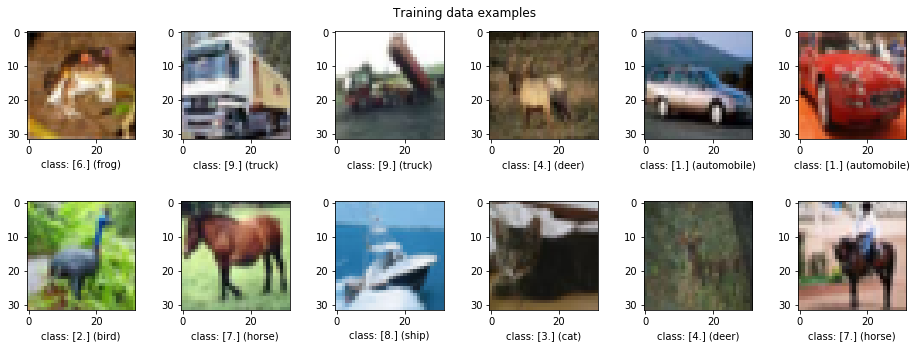

In [9]:
fig = plt.figure(figsize=(13, 5))
for i in range(12):
    plt.subplot(2, 6, i+1)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(X_train[i])
    plt.xlabel('class: {} ({})'.format(y_train[i], n_to_class[y_train[i, 0]]))
plt.suptitle('Training data examples')
plt.tight_layout()


## Define the CNN model

In [27]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()

In [28]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

The Keras sequential model is a linear stack of layers.<br>
The model needs to know the expected input shape therefore the first layer of this Sequential model needs to get information about its input shape. You can do this by passing the input_shape argument. <br>

The human performance on the CIFAR-10 dataset is around 94% accuracy while state of the art approaches have already surpassed that value by showing an accuracy over 96%. You can find more about these results [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130). <br>

You may try different architectures with more layers or different optimizers.
Look at the link above and read the respective publications to get inspired. Just take note that training deeper networks (especially if you are not using GPU) will take longer.

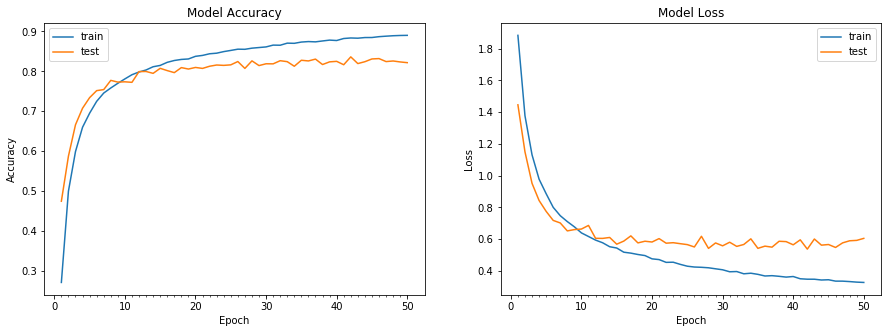

Model took 957.04 seconds to train
Accuracy on test data is: 82.17


In [30]:
# Define the model
model = Sequential()
model.add(Convolution2D(48, (3, 3), padding='same', input_shape=(32, 32,3)))
model.add(Activation('relu'))
model.add(Convolution2D(48, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(96, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(192, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(192, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
start = time.time()
model_info = model.fit(X_train, labels_train, 
                       batch_size=128, epochs=50, 
                       validation_data = (X_test, labels_test), 
                       verbose=0)
end = time.time()
# plot model history
plot_model_history(model_info)
print("Model took %0.2f seconds to train"%(end - start))
# compute test accuracy
print("Accuracy on test data is: %0.2f"%accuracy(X_test, labels_test, model))